# Comparing Support Vector Machines, Decision Trees and Naive Bayes for Heart Failure Prediction

Notebook for workshop assignment [Workshop: Compare Support Vector Machines to DTs and NB](https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971)

In [16]:
# Notebook for Workshop: Compare Support Vector Machines, DTs and NB
# https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.base import BaseEstimator, ClassifierMixin 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, get_scorer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [17]:
pd.set_option("display.max_columns", None)

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [18]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Analysis and Processing

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

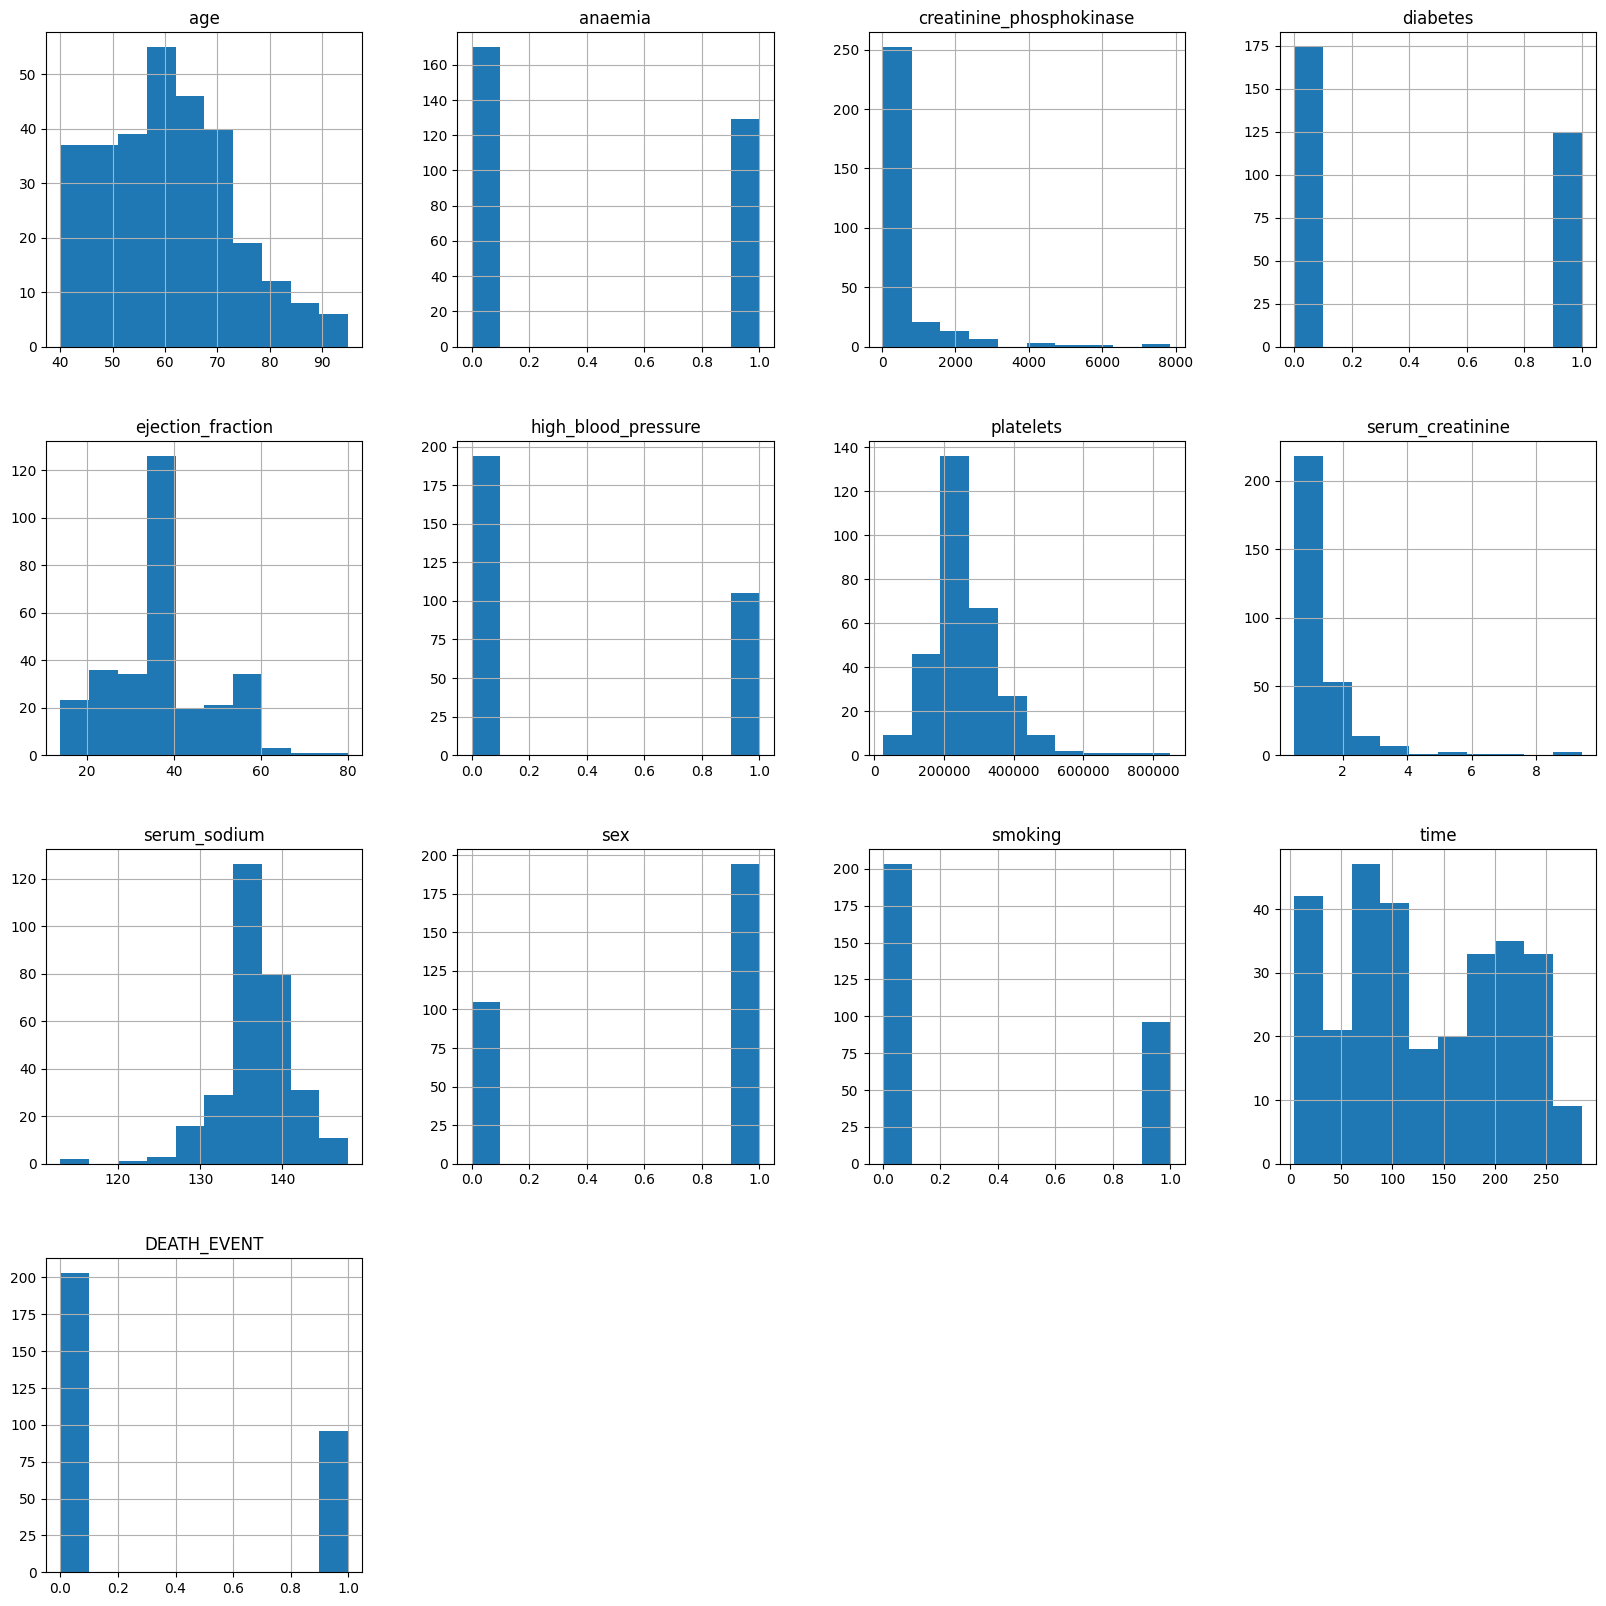

In [19]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training. 
# This should be improved.

dataset.hist(figsize=(20,20))

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

## Training & Tuning

In [20]:
# Split into 80/20. 80% for cross validated training, and 20% for final testing

trainval = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)

In [21]:
# Separate input features from targets in all partitions

features = dataset.drop('DEATH_EVENT', axis=1)
targets = dataset['DEATH_EVENT']
trainval_features = trainval.drop('DEATH_EVENT', axis=1)
trainval_targets = trainval['DEATH_EVENT']
test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test['DEATH_EVENT']


In [22]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc.
# Works well for when your data partitions are fixed.
def evaluate(model):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(trainval_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(trainval_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(trainval_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(trainval_targets, train_predictions)}')
    print(f'Training F1: {f1_score(trainval_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(trainval_targets, train_probabilities[:,1])}')
    
    # Evaluate and print the final test scores     

    test_probabilities = model.predict_proba(test_features)
    test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

    print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
    print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
    print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
    print(f'Test F1: {f1_score(test_targets, test_predictions)}')
    print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')
    print()

In [23]:
# A function for running tests on specified data
def evaluate2(estimator, X, y):
    # Get the prediction probabilities for each class
    probabilities = estimator.predict_proba(X)
    # Get the indices of the highest probabilities for each prediction
    prediction_indices = np.argmax(probabilities, axis=1)
    # Build a list with the appropriate class labels for each prediction
    predictions = estimator.classes_.take(prediction_indices, axis=0)

    return {
        'accuracy': accuracy_score(y, predictions), 
        'precision': precision_score(y, predictions), 
        'recall': recall_score(y, predictions), 
        'f1': f1_score(y, predictions), 
        'roc_auc': roc_auc_score(y, probabilities[:,1]), 
        }

In [24]:
# A custom function for returning the results for all metrics based on the best f1 score on test data
def show_cv_results(cv_results):
    # Sort the values in the frame according to their rank in f1
    sorted_results = cv_results.sort_values('rank_test_f1',ascending=True)
    # return the relevant scores for the first row of the data
    return sorted_results[['mean_train_f1', 'mean_train_precision', 'mean_train_recall', 'mean_train_accuracy', 'mean_train_roc_auc', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'mean_test_roc_auc']].iloc[0]

In [25]:
# Define the metrics that we wan't to use. The names of available scorers can be accessed through
# get_scorer_names. The actual scorer objects are found using get_scorer. This is done internally in all sklearn 
# functions that accept metric names
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [26]:
# Train a decision tree using grid search and nested cross validation. A nested CV setup is 
# the best way of training, hyperparameter tuning, and a final evaluation on unseen test data.

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': range(1,21)
    # Needs to be expanded with more parameters
}

# Define our stratified kfold iterators, one for the outer iterations through the external test folds
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
# and one to be used by GridSearchCV in the inner iterations through the validation folds that is used to
# validate the performance hyperparameter values. The training data will consist of the remaining three 
# folds in each iteration. 
# Note that we pass in the same random seed to each iterator. We can now fix the random seed as we 
# are using the entire dataset for final testing irregardles of seed. 
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

# Create lists for storing our results
dt_cv_results = []
dt_estimators = []
dt_test_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': [],
}

# The iterators are used to split the data into training and test data
for (train_index, test_index) in list(outer_cv.split(features, targets)):

    # Employ grid search to find the hyperparameter values in the specified grid. We pass in the 
    # inner cv iterator
    dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=inner_cv, scoring=metrics, refit='f1',return_train_score=True)

    # Perform cross validated training and tuning on the current training and validation data
    dt_grid.fit(features.iloc[train_index], targets.iloc[train_index])

    # Store the cv results for current iteration
    cv_results = pd.DataFrame(dt_grid.cv_results_)
    dt_cv_results.append(cv_results)

    # Store the best estimator for the current iteration
    dt_estimators.append(dt_grid.best_estimator_)

    # Evaluate and store the scores of the best estimator on the current test fold
    evaluation = evaluate2(dt_grid, features.iloc[test_index], targets.iloc[test_index])
    dt_test_scores['accuracy'].append(evaluation['accuracy'])
    dt_test_scores['precision'].append(evaluation['precision'])
    dt_test_scores['recall'].append(evaluation['recall'])
    dt_test_scores['f1'].append(evaluation['f1'])
    dt_test_scores['roc_auc'].append(evaluation['roc_auc'])
    

In [27]:
# Convert the scores into a dataframe
dt_test_scores = pd.DataFrame(dt_test_scores)
# Show the mean scores across all test folds
dt_test_scores.mean()

accuracy     0.782260
precision    0.682941
recall       0.614211
f1           0.644392
roc_auc      0.766518
dtype: float64

In [28]:
# Concat the cv_result frames together
cv_results_frame = pd.concat(dt_cv_results, names=['test_split'], keys=range(5), axis=0)
# Find the best scores for each split according to the maximum f1 scores
cv_scores = cv_results_frame.groupby('test_split').apply(lambda frame: frame.sort_values('rank_test_f1')[['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].iloc[0])
# Show the cross validation results (no training results selected)
cv_scores


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
test_split,,,,,
0,0.853531,0.855611,0.657895,0.740659,0.801280
1,0.849011,0.886905,0.649342,0.739773,0.796622
2,0.819703,0.731746,0.752632,0.732362,0.818270
3,0.828107,0.735819,0.753289,0.740715,0.862612
4,0.841667,0.733465,0.805263,0.767000,0.831976


In [29]:
# Print the best estimators to verify that we have trained a different classifier for each 
# split (under the assumption that the best parameter values will be different between the iterations)
print(dt_estimators)

[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(criterion='entropy', max_depth=3), DecisionTreeClassifier(criterion='entropy', max_depth=3), DecisionTreeClassifier(max_depth=13)]


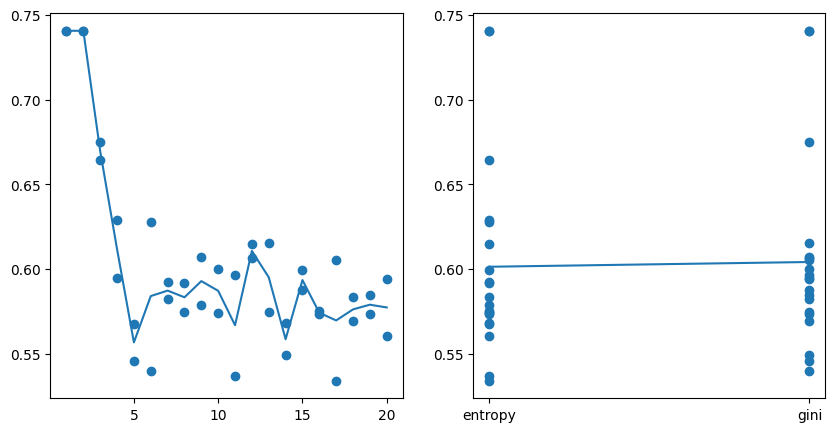

In [30]:
# Investigate the performance of the different parameter values using pyplot
# This works for a single cv_result only, and the setup would have to be modified for 
# accounting for nested cross validation. I've added an index ([0]) to keep the code working

# Create a new frame with the relevant columns. We have tuned two parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
dt_param_scores = dt_cv_results[0][['param_max_depth', 'param_criterion', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average max_depth performance 
# accross the other parameter values
dt_max_depth = dt_param_scores.pivot_table(index='param_criterion', columns='param_max_depth', values='mean_test_f1')
dt_max_depth_means = dt_max_depth.mean(axis=0)

# A frame to find the average performance of each criteria value
dt_criterion = dt_param_scores.pivot_table(index='param_max_depth', columns='param_criterion', values='mean_test_f1')
dt_criterion_means = dt_criterion.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(dt_max_depth_means.index, dt_max_depth_means)
ax[0].scatter(dt_cv_results[0]['param_max_depth'], dt_cv_results[0]['mean_test_f1'])
ax[1].plot(dt_criterion_means.index, dt_criterion_means)
ax[1].scatter(dt_cv_results[0]['param_criterion'], dt_cv_results[0]['mean_test_f1'])
plt.show()


<Axes: xlabel='param_max_depth', ylabel='mean_test_f1'>

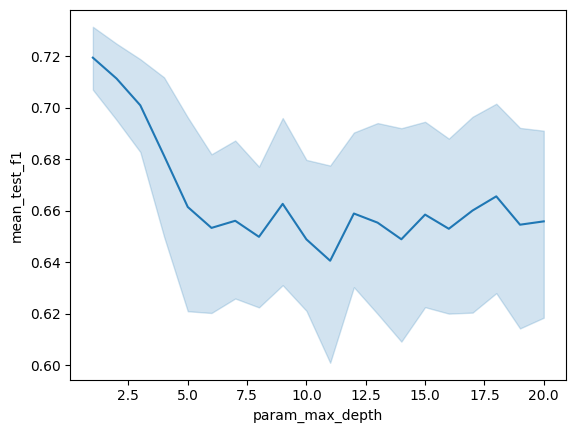

In [31]:
# Evaluate the performance of a parameter value accross all test splits (and other parameter values)
# We reset the index to be able to set a new index. This will make the test_split index become a 
# column
cv_results_frame.reset_index(inplace=True)
# Fetch all relevant columns
param_scores = cv_results_frame[['test_split', 'param_max_depth', 'param_criterion', 'mean_test_f1']]
# Set the desired index. In this case we set every thin except the score. This makes us able to access 
# values in groups according to what indices we specify
param_scores = param_scores.set_index(['test_split', 'param_max_depth', 'param_criterion'])

# Plot the scores for param_max_depth
sb.lineplot(data=param_scores, x='param_max_depth', y='mean_test_f1')


In [32]:
# This function only works for a single cv_results (not nested CV)
show_cv_results(dt_cv_results[0])

mean_train_f1           0.740741
mean_train_precision    0.848357
mean_train_recall       0.657895
mean_train_accuracy     0.853554
mean_train_roc_auc      0.801333
mean_test_f1            0.740659
mean_test_precision     0.855611
mean_test_recall        0.657895
mean_test_accuracy      0.853531
mean_test_roc_auc       0.801280
Name: 0, dtype: float64

In [33]:
# This function only works for a single cv_results (not nested CV)
evaluate(dt_estimators[0])

Training Accuracy: 0.8242677824267782
Training Precision: 0.7868852459016393
Training Recall: 0.6233766233766234
Training F1: 0.6956521739130435
Training ROC AUC: 0.7715648548981883
Test Accuracy: 0.9333333333333333
Test Precision: 1.0
Test Recall: 0.7894736842105263
Test F1: 0.8823529411764706
Test ROC AUC: 0.8947368421052632



In [34]:
# Calculate the confusion matrix for the best decision tree model. This works because 
# dt_grid is still available from the last iteration through the outer CV loop

confusion_matrix(test_targets, dt_grid.predict(test_features))

array([[40,  1],
       [ 2, 17]])

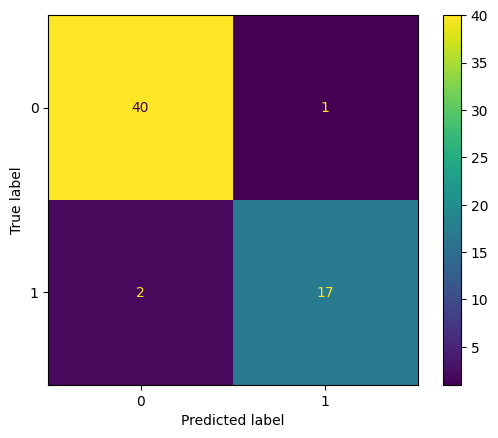

In [35]:
# The ConfusionMatrixDisplay class can be used to make confusion matrix plots. This works because 
# dt_grid is still available from the last iteration through the outer CV loop

ConfusionMatrixDisplay.from_estimator(dt_grid, test_features, test_targets)

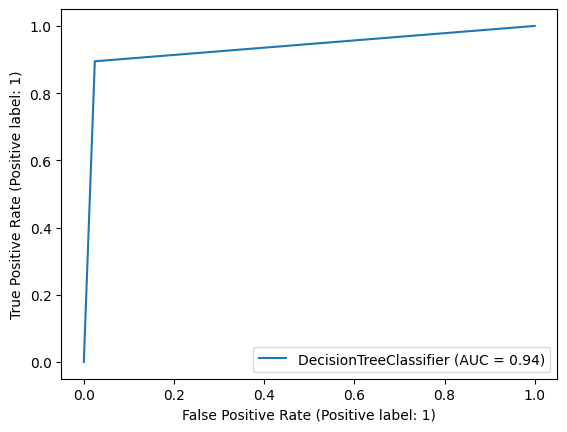

In [36]:
# Plot the ROC curve for the best decision tree model

# These two statements achieves the same thing
# RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
RocCurveDisplay.from_estimator(dt_grid.best_estimator_, test_features, test_targets)

In [37]:
# Train and evaluate a gaussian naive bayesian classifier with default parameters

nb_params = {
    'var_smoothing': np.logspace(-10, -5, 6) # The values are specified with the exponents i.e. 1e-10, ..., 1e-5
}
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1', return_train_score=True)
nb_grid.fit(trainval_features, trainval_targets)
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.001355,0.000262,0.005305,0.000316,0.0,{'var_smoothing': 1e-10},0.770833,0.770833,0.854167,0.687500,0.702128,0.757092,0.059439,3,0.780105,0.774869,0.759162,0.780105,0.807292,0.780307,0.015524,0.700000,0.833333,1.0,0.545455,0.545455,0.724848,0.174619,4,0.794118,0.731707,0.714286,0.787879,0.790698,0.763737,0.033776,0.466667,0.333333,0.5625,0.3750,0.400000,0.427500,0.080173,2,0.435484,0.483871,0.409836,0.426230,0.548387,0.460762,0.050273,0.560000,0.476190,0.720000,0.444444,0.461538,0.532435,0.101855,2,0.562500,0.582524,0.520833,0.553191,0.647619,0.573334,0.042148,0.765657,0.929293,0.882812,0.751953,0.804167,0.826776,0.068549,1,0.865216,0.843836,0.838209,0.885876,0.873077,0.861243,0.017867
1,0.001205,0.000042,0.004974,0.000090,0.0,{'var_smoothing': 1e-09},0.791667,0.791667,0.854167,0.729167,0.723404,0.778014,0.048042,1,0.785340,0.785340,0.790576,0.785340,0.812500,0.791819,0.010537,0.727273,0.857143,1.0,0.636364,0.583333,0.760823,0.151395,2,0.818182,0.744186,0.783784,0.794118,0.782609,0.784576,0.023901,0.533333,0.400000,0.5625,0.4375,0.466667,0.480000,0.060058,1,0.435484,0.516129,0.475410,0.442623,0.580645,0.490058,0.053533,0.615385,0.545455,0.720000,0.518519,0.518519,0.583575,0.076865,1,0.568421,0.609524,0.591837,0.568421,0.666667,0.600974,0.036308,0.771717,0.876768,0.865234,0.787109,0.800000,0.820166,0.042618,2,0.850463,0.842461,0.834048,0.862421,0.859677,0.849814,0.010576
2,0.001264,0.000099,0.004959,0.000104,0.0,{'var_smoothing': 1e-08},0.729167,0.791667,0.854167,0.708333,0.723404,0.761348,0.054443,2,0.780105,0.795812,0.769634,0.774869,0.817708,0.787625,0.017407,0.625000,0.857143,1.0,0.666667,0.583333,0.746429,0.157647,3,0.857143,0.780488,0.742857,0.846154,0.813953,0.808119,0.042206,0.333333,0.400000,0.5625,0.2500,0.466667,0.402500,0.107484,3,0.387097,0.516129,0.426230,0.360656,0.564516,0.450925,0.077443,0.434783,0.545455,0.720000,0.363636,0.518519,0.516478,0.120249,3,0.533333,0.621359,0.541667,0.505747,0.666667,0.573755,0.060311,0.741414,0.872727,0.847656,0.822266,0.806250,0.818063,0.044489,3,0.837334,0.823081,0.818159,0.831652,0.839702,0.829986,0.008231
3,0.001183,0.000109,0.005283,0.000298,0.0,{'var_smoothing': 1e-07},0.708333,0.750000,0.770833,0.729167,0.787234,0.749113,0.028237,4,0.743455,0.764398,0.759162,0.748691,0.812500,0.765641,0.024571,0.571429,0.800000,1.0,0.800000,0.692308,0.772747,0.141513,1,0.809524,0.742857,0.777778,0.782609,0.825000,0.787553,0.028294,0.266667,0.266667,0.3125,0.2500,0.600000,0.339167,0.132067,4,0.274194,0.

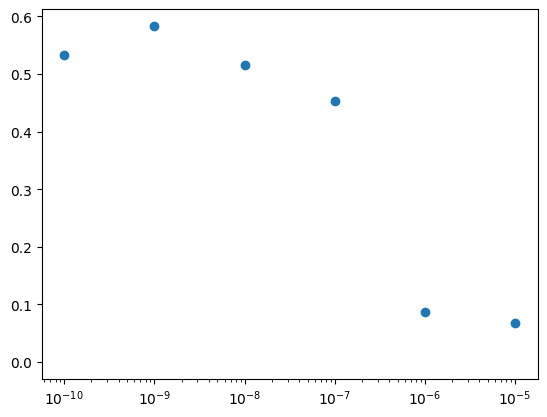

In [38]:
fig, ax = plt.subplots(1,1)
ax.semilogx(1e-10, 0)
plt.scatter(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])

In [39]:
show_cv_results(nb_cv_results)

mean_train_f1           0.600974
mean_train_precision    0.784576
mean_train_recall       0.490058
mean_train_accuracy     0.791819
mean_train_roc_auc      0.849814
mean_test_f1            0.583575
mean_test_precision     0.760823
mean_test_recall        0.480000
mean_test_accuracy      0.778014
mean_test_roc_auc       0.820166
Name: 1, dtype: float64

* The two models performs exactly the same on test data, which makes us have to fall back to validation data in determining which models is the best
* nb1 is the better of the two for validation data. (Individual metrics should be discussed)

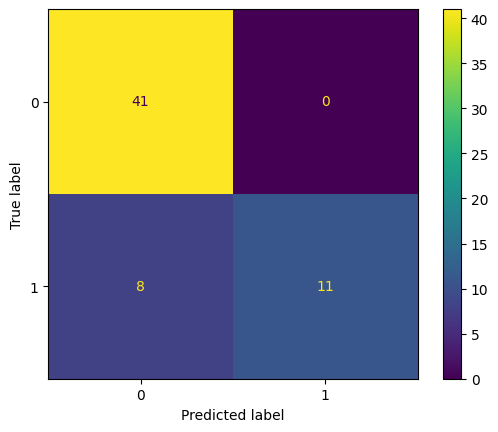

In [40]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb_grid, test_features, test_targets)

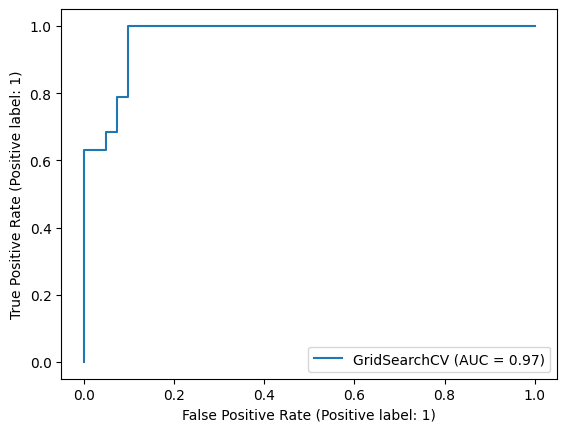

In [41]:
RocCurveDisplay.from_estimator(nb_grid, test_features, test_targets)

In [52]:
class CombinedNB(ClassifierMixin, BaseEstimator):

    def __init__(self, gaussian=GaussianNB(), gaussian_features=None, bernoulli=BernoulliNB(), bernoulli_features=None):
        
        self.gaussian_features = gaussian_features
        self.bernoulli_features  = bernoulli_features
        
        self.gaussian = gaussian 
        self.bernoulli = bernoulli 

    def fit(self, X, y):
        self.gaussian.fit(X[self.gaussian_features], y)
        self.bernoulli.fit(X[self.bernoulli_features], y)
        self.classes_ = self.gaussian.classes_
       

    def predict(self, X):
        predict_proba = self.predict_proba(X)
            
        return np.argmax(predict_proba, axis=1)

    def predict_proba(self, X):
        gaussian_proba = self.gaussian.predict_proba(X[self.gaussian_features])
        bernoulli_proba = self.bernoulli.predict_proba(X[self.bernoulli_features])
        proba = gaussian_proba * bernoulli_proba
        return proba


In [63]:
combined_params = {
    'gaussian__var_smoothing':np.logspace(-10, -5, 6),
    'bernoulli__alpha': np.logspace(-4, 0, 5)
}
gaussian_features = [
    'age', 
    'creatinine_phosphokinase', 
    'ejection_fraction', 
    'platelets',  
    'serum_creatinine', 
    'serum_sodium', 
    'time' ]
bernoulli_features = list(filter(lambda x: x not in gaussian_features, trainval_features.columns))
grid_combined = GridSearchCV(
    CombinedNB(gaussian_features=gaussian_features, bernoulli_features=bernoulli_features), 
    combined_params, 
    scoring=metrics,
    refit='f1', 
    return_train_score=True)
# combined = CombinedNB(gaussian_features=gaussian_features, bernoulli_features=bernoulli_features)
# combined.fit(trainval_features, trainval_targets)
grid_combined.fit(trainval_features, trainval_targets)
combined_cv_results = pd.DataFrame(grid_combined.cv_results_)

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification

In [64]:
show_cv_results(combined_cv_results)

mean_train_f1           0.474829
mean_train_precision    0.772260
mean_train_recall       0.344051
mean_train_accuracy     0.756261
mean_train_roc_auc      0.851717
mean_test_f1            0.420297
mean_test_precision     0.718333
mean_test_recall        0.299167
mean_test_accuracy      0.736525
mean_test_roc_auc       0.805137
Name: 0, dtype: float64

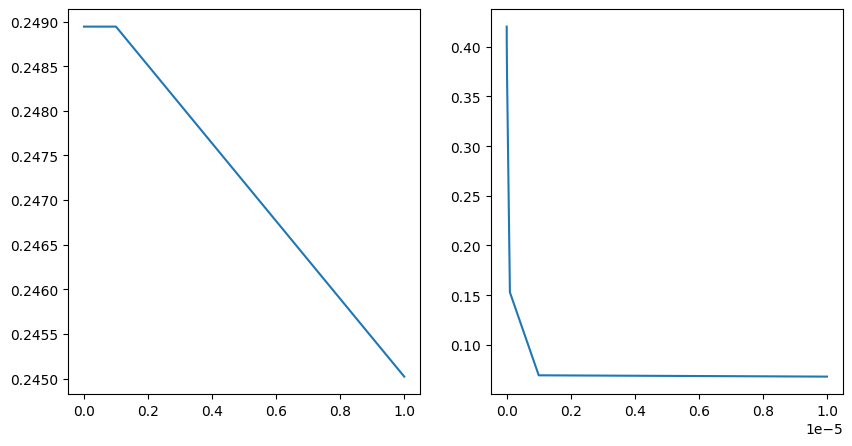

In [61]:
# Create a new frame with the relevant columns. We have tuned two parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
combined_param_scores = combined_cv_results[['param_gaussian__var_smoothing', 'param_bernoulli__alpha', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average max_depth performance 
# accross the other parameter values
combined_var_smoothing = combined_param_scores.pivot_table(index='param_bernoulli__alpha', columns='param_gaussian__var_smoothing', values='mean_test_f1')
combined_var_smoothing_means = combined_var_smoothing.mean(axis=0)

# A frame to find the average performance of each criteria value
combined_alpha = combined_param_scores.pivot_table(index='param_gaussian__var_smoothing', columns='param_bernoulli__alpha', values='mean_test_f1')
combined_alpha_means = combined_alpha.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(combined_alpha_means.index, combined_alpha_means)
ax[1].plot(combined_var_smoothing_means.index, combined_var_smoothing_means)
plt.show()

In [45]:
svc_params = {
    'C': [0.5, 1.0, 2.0, 4.0], 
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None]
}
svc_grid = GridSearchCV(SVC(probability=True), svc_params, scoring=metrics, refit='f1', return_train_score=True)
svc_grid.fit(trainval_features, trainval_targets)
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)
svc_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,split3_train_recall,split4_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,split3_train_f1,split4_train_f1,mean_train_f1,std_train_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.005314,0.000141,0.006129,0.000325,0.5,balanced,rbf,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.604167,0.645833,0.666667,0.666667,0.574468,0.631560,0.036547,12,0.643979,0.659686,0.654450,0.670157,0.625000,0.650654,0.015356,0.166667,0.250000,0.500000,0.500000,0.272727,0.337879,0.137002,3,0.425000,0.428571,0.368421,0.428571,0.352941,0.400701,0.033066,0.066667,0.066667,0.1250,0.0625,0.200000,0.104167,0.053229,14,0.274194,0.145161,0.114754,0.098361,0.193548,0.165204,0.063399,0.095238,0.105263,0.200000,0.111111,0.230769,0.148476,0.055722,12,0.333333,0.216867,0.175000,0.160000,0.250000,0.227040,0.061857,0.464646,0.525253,0.416016,0.373047,0.343750,0.424542,0.064812,24,0.524881,0.560890,0.563556,0.599496,0.526179,0.555000,0.027661
1,0.004862,0.000413,0.005712,0.000209,0.5,balanced,poly,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.312500,0.312500,0.333333,0.333333,0.382979,0.334929,0.025768,21,0.329843,0.329843,0.324607,0.324607,0.328125,0.327405,0.002369,0.312500,0.312500,0.333333,0.333333,0.333333,0.325000,0.010206,5,0.326316,0.326316,0.321053,0.321053,0.320856,0.323118,0.002612,1.000000,1.000000,1.0000,1.0000,0.933333,0.986667,0.026667,1,1.000000,1.000000,1.000000,1.000000,0.967742,0.993548,0.012903,0.476190,0.476190,0.500000,0.500000,0.491228,0.488722,0.010721,1,0.492063,0.492063,0.486056,0.486056,0.481928,0.487633,0.003919,0.541414,0.521212,0.576172,0.419922,0.410417,0.493827,0.066655,20,0.489997,0.497874,0.483102,0.517907,0.521340,0.502044,0.015134
2,0.006847,0.000107,0.006010,0.000377,0.5,balanced,sigmoid,"{'C': 0.5, 'class_weight': 'balanced', 'kernel...",0.395833,0.625000,0.666667,0.666667,0.680851,0.607004,0.107228,14,0.361257,0.554974,0.680628,0.680628,0.677083,0.590914,0.124545,0.333333,0.400000,0.000000,0.000000,0.000000,0.146667,0.180862,13,0.300000,0.338028,0.000000,0.000000,0.000000,0.127606,0.156746,0.933333,0.400000,0.0000,0.0000,0.000000,0.266667,0.367575,9,0.725806,0.387097,0.000000,0.000000,0.000000,0.222581,0.292892,0.491228,0.400000,0.000000,0.000000,0.000000,0.178246,0.220203,9,0.424528,0.360902,0.000000,0.000000,0.000000,0.157086,0.193440,0.525253,0.517172,0.578125,0.398438,0.681250,0.540047,0.091852,2,0.476994,0.489247,0.482472,0.513619,0.514764,0.495419,0.015816
3,0.004219,0.000070,0.005874,0.000218,0.5,None,rbf,"{'C': 0.5, 'class_weight': None, 'kernel': 'rbf'}",0.687500,0.687500,0.666667,0.666667,0.680851,0.677837,0.009438,2,0.675393,0.675393,0.680628,0.680628,0.677083,0.677825,

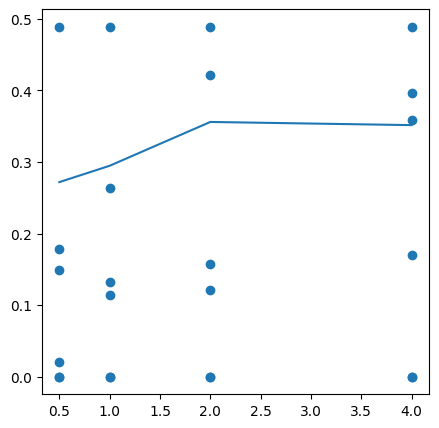

In [46]:
# Investigate the performance of the different parameter values

# Create a new frame with the relevant columns. We have tuned three parameters so far, and we want to find the best 
# values according to the f1 test (validation) results
svc_param_scores = svc_cv_results[['param_C', 'param_class_weight', 'param_kernel', 'mean_test_f1']]

# Create a new frame where we have organized the values that we can find the average C performance 
# accross the other parameter values
svc_c = svc_param_scores.pivot_table(index=['param_class_weight','param_kernel'], columns='param_C', values='mean_test_f1')
svc_c_means = svc_c.mean(axis=0)

# Plot everything, one plot for each parameter tuned
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(svc_c_means.index, svc_c_means)
ax.scatter(svc_cv_results['param_C'], svc_cv_results['mean_test_f1'])
plt.show()


In [47]:
show_cv_results(svc_cv_results)

mean_train_f1           0.487633
mean_train_precision    0.323118
mean_train_recall       0.993548
mean_train_accuracy     0.327405
mean_train_roc_auc      0.502044
mean_test_f1            0.488722
mean_test_precision     0.325000
mean_test_recall        0.986667
mean_test_accuracy      0.334929
mean_test_roc_auc       0.493827
Name: 1, dtype: float64

In [48]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation metrics, but more evaluation 
# methods should be employed

evaluate(dt_grid.best_estimator_)
evaluate(nb_grid.best_estimator_)
evaluate(svc_grid.best_estimator_)

Training Accuracy: 0.9330543933054394
Training Precision: 0.8961038961038961
Training Recall: 0.8961038961038961
Training F1: 0.8961038961038962
Training ROC AUC: 0.9233605900272567
Test Accuracy: 0.95
Test Precision: 0.9444444444444444
Test Recall: 0.8947368421052632
Test F1: 0.918918918918919
Test ROC AUC: 0.9351732991014121

Training Accuracy: 0.7949790794979079
Training Precision: 0.7916666666666666
Training Recall: 0.4935064935064935
Training F1: 0.6079999999999999
Training ROC AUC: 0.8431938431938433
Test Accuracy: 0.8666666666666667
Test Precision: 1.0
Test Recall: 0.5789473684210527
Test F1: 0.7333333333333334
Test ROC AUC: 0.9691912708600771

Training Accuracy: 0.6778242677824268
Training Precision: 0.0
Training Recall: 0.0
Training F1: 0.0
Training ROC AUC: 0.4971941638608305
Test Accuracy: 0.6833333333333333
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test ROC AUC: 0.38510911424903715



/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on the metrics shown above we have to conclude that that dt2 is the best classifier for predicting heart failures. Both the confusion matrices and the ROC plots confirm the results. Both classifiers have a significant amount of false negatives, which makes both models complicate to implement in healthcare practice. 

The results are highly dependent on the random sampling in the data partitions. A more thorough analysis is needed to overcome this issue.